# Rag From Scratch: Routing

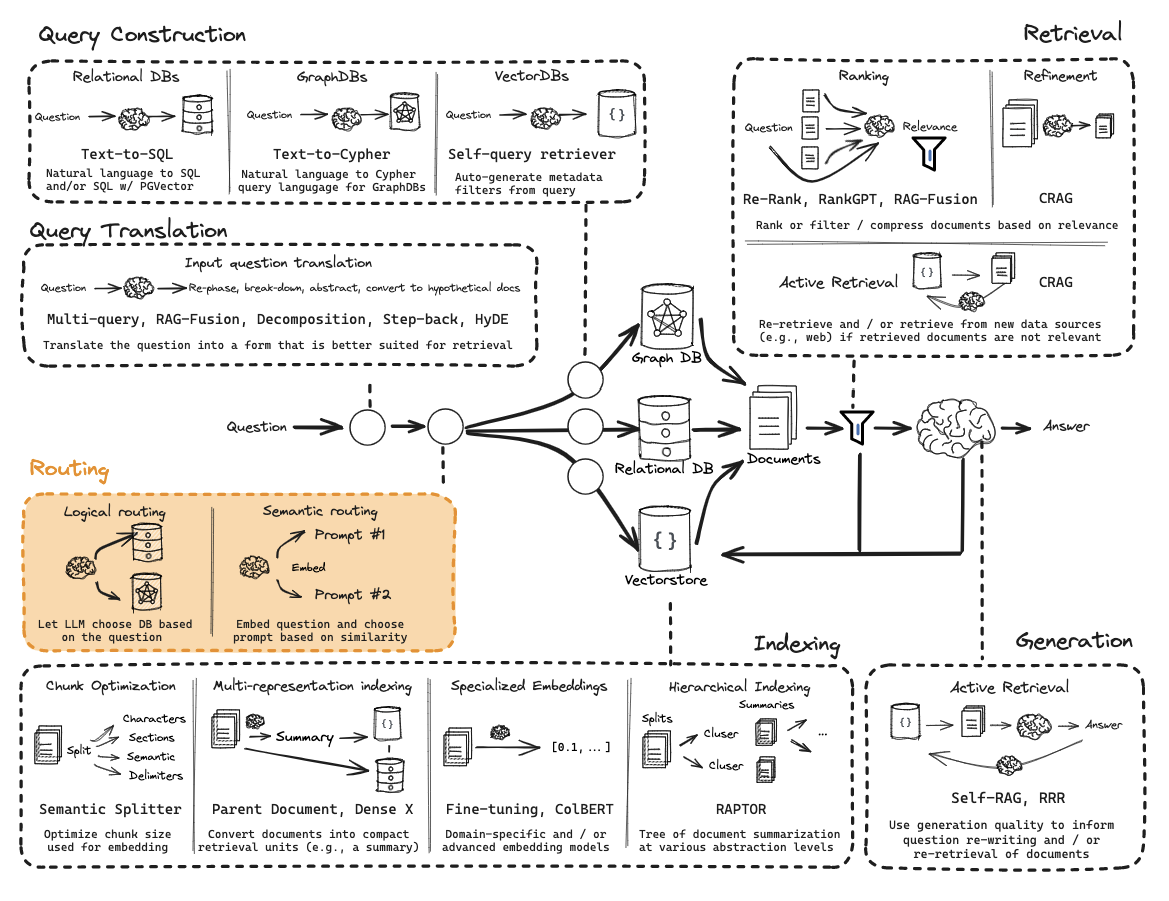

### Environment
(1) Packages

In [1]:
# ! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain youtube-transcript-api pytube

(2) LangSmith

In [2]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
from dotenv import load_dotenv

LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
HUGGINGFACEHUB_API_TOKEN = os.getenv("HUGGINGFACEHUB_API_TOKEN")

(3) API Keys

In [3]:
# os.environ['OPENAI_API_KEY'] = <your-api-key>

## Part 10: Logical and Semantic routing

Use function-calling for classification.

Flow:

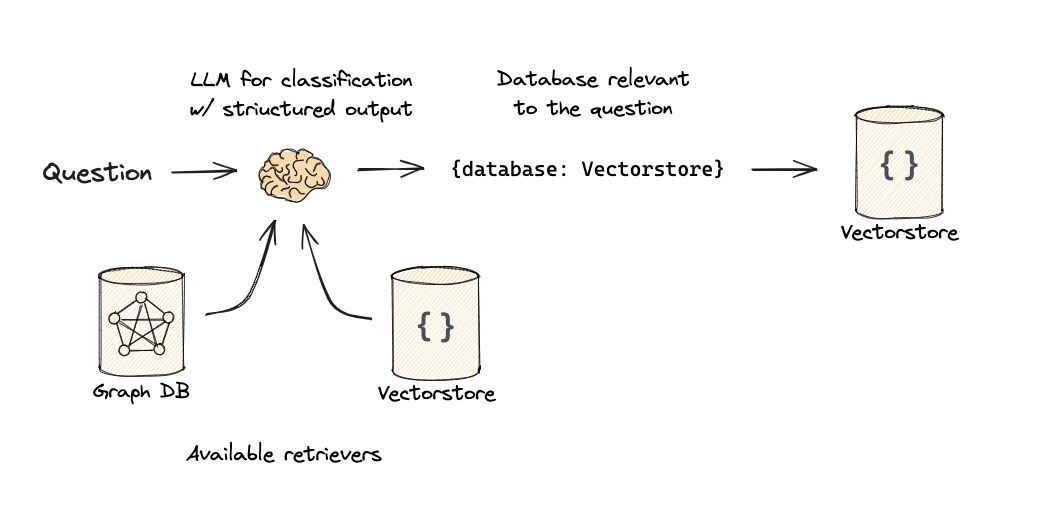

In [4]:
from typing import Literal
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.llms import Ollama
from langchain.output_parsers import PydanticOutputParser

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""
    datasource: Literal["python_docs", "js_docs", "golang_docs"] = Field(
        ..., 
        description="Given a user question choose which datasource would be most relevant for answering their question",
    )

# LLM with function call
llm = Ollama(model='llama3.2')

# Use PydanticOutputParser for structured output
parser = PydanticOutputParser(pydantic_object=RouteQuery)

# ✅ Correct usage for Pydantic v2
format_instructions = parser.get_format_instructions()

# System prompt (Adding format instructions)
system = f"""You are an expert in routing user questions to the appropriate data source.
Analyze the given question and return a JSON object that follows this format:

{format_instructions}
"""

# ChatPromptTemplate with structured output instructions
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# Define router (Apply the output parser in the chain)
router = prompt | llm | parser

/var/folders/42/94lj0cp519ncj7_m79j3_h3m0000gn/T/ipykernel_46614/966157407.py:16: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model='llama3.2')


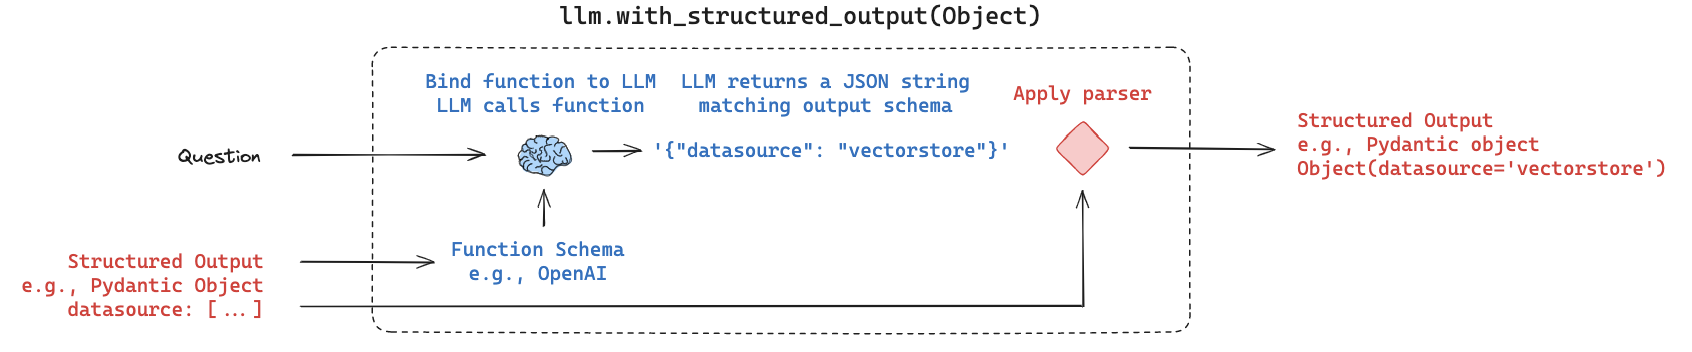

In [ ]:
question = """Why doesn't the following code work:

from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([("human", "speak in {language}")])
prompt.invoke({"language": "french"})
"""

result = router.invoke({"question": question})

/opt/anaconda3/envs/ollama-rag/lib/python3.11/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


KeyError: 'Input to ChatPromptTemplate is missing variables {\'"description"\', \'"foo"\', \'"properties"\'}.  Expected: [\'"description"\', \'"foo"\', \'"properties"\', \'question\'] Received: [\'question\']\nNote: if you intended {"description"} to be part of the string and not a variable, please escape it with double curly braces like: \'{{"description"}}\'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT '

Failed to multipart ingest runs: langsmith.utils.LangSmithAuthError: Authentication failed for https://api.smith.langchain.com/runs/multipart. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Unauthorized"}\n')trace=36497264-a2fd-4308-a9a7-bc8a0674356e,id=36497264-a2fd-4308-a9a7-bc8a0674356e; trace=36497264-a2fd-4308-a9a7-bc8a0674356e,id=e0533f31-e468-4840-be2d-b11b8c5856ea


In [ ]:
result

NameError: name 'result' is not defined

In [ ]:
result.datasource

NameError: name 'result' is not defined

In [ ]:
def choose_route(result):
    if "python_docs" in result.datasource.lower():
        ### Logic here 
        return "chain for python_docs"
    elif "js_docs" in result.datasource.lower():
        ### Logic here 
        return "chain for js_docs"
    else:
        ### Logic here 
        return "golang_docs"

from langchain_core.runnables import RunnableLambda

full_chain = router | RunnableLambda(choose_route)

In [ ]:
full_chain.invoke({"question": question})

KeyError: 'Input to ChatPromptTemplate is missing variables {\'"foo"\', \'"properties"\', \'"description"\'}.  Expected: [\'"description"\', \'"foo"\', \'"properties"\', \'question\'] Received: [\'question\']\nNote: if you intended {"foo"} to be part of the string and not a variable, please escape it with double curly braces like: \'{{"foo"}}\'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT '

## Semantic routing
flow

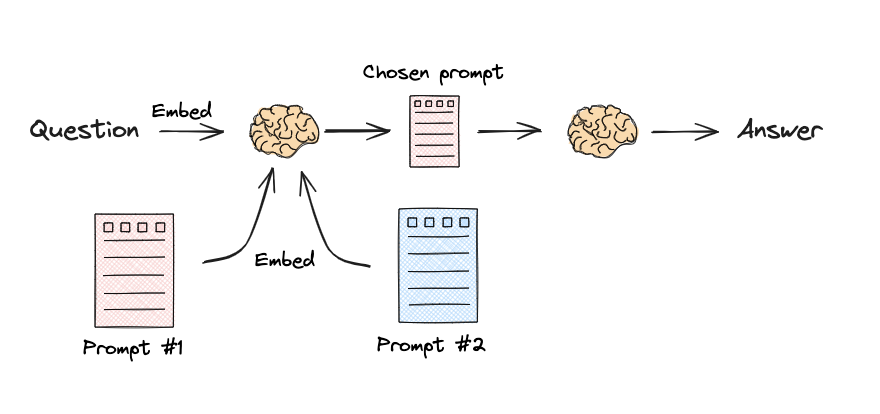

In [ ]:
from langchain.utils.math import cosine_similarity
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.llms import Ollama
from langchain_community.embeddings import HuggingFaceEmbeddings

# Two prompts
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise and easy to understand manner. \
When you don't know the answer to a question you admit that you don't know.

Here is a question:
{query}"""

math_template = """You are a very good mathematician. You are great at answering math questions. \
You are so good because you are able to break down hard problems into their component parts, \
answer the component parts, and then put them together to answer the broader question.

Here is a question:
{query}"""

# Embed prompts
# embeddings = OpenAIEmbeddings()
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
prompt_templates = [physics_template, math_template]
prompt_embeddings = embeddings.embed_documents(prompt_templates)

# Route question to prompt 
def prompt_router(input):
    # Embed question
    query_embedding = embeddings.embed_query(input["query"])
    # Compute similarity
    similarity = cosine_similarity([query_embedding], prompt_embeddings)[0]
    most_similar = prompt_templates[similarity.argmax()]
    # Chosen prompt 
    print("Using MATH" if most_similar == math_template else "Using PHYSICS")
    return PromptTemplate.from_template(most_similar)


llm = Ollama(model= 'llama3.2')
chain = (
    {"query": RunnablePassthrough()}
    | RunnableLambda(prompt_router)
    | llm
    | StrOutputParser()
)

print(chain.invoke("What's a black hole"))

/var/folders/42/94lj0cp519ncj7_m79j3_h3m0000gn/T/ipykernel_41118/1131311147.py:26: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/opt/anaconda3/envs/ollama-rag/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using PHYSICS
Black holes are one of the most fascinating objects in the universe.

A black hole is essentially a region in space where the gravitational pull is so strong that nothing, not even light, can escape once it gets too close. This happens when a massive star collapses in on itself and its gravity becomes so strong that it warps the fabric of spacetime around it.

Imagine spacetime as a trampoline: if you place a heavy object, like a bowling ball, on it, it will warp the surface, creating a curve. Now imagine taking that same bowling ball and moving it even closer to the edge of the trampoline. The curve becomes even more extreme, creating a sort of "sinkhole" where anything that gets too close gets pulled in.

That's roughly what happens with a black hole: the intense gravity creates an event horizon, which marks the point of no return around a black hole. If you cross this boundary, you'll be trapped by the black hole's gravity and won't be able to escape.

One of the most 

# Rag From Scratch: Query Construction

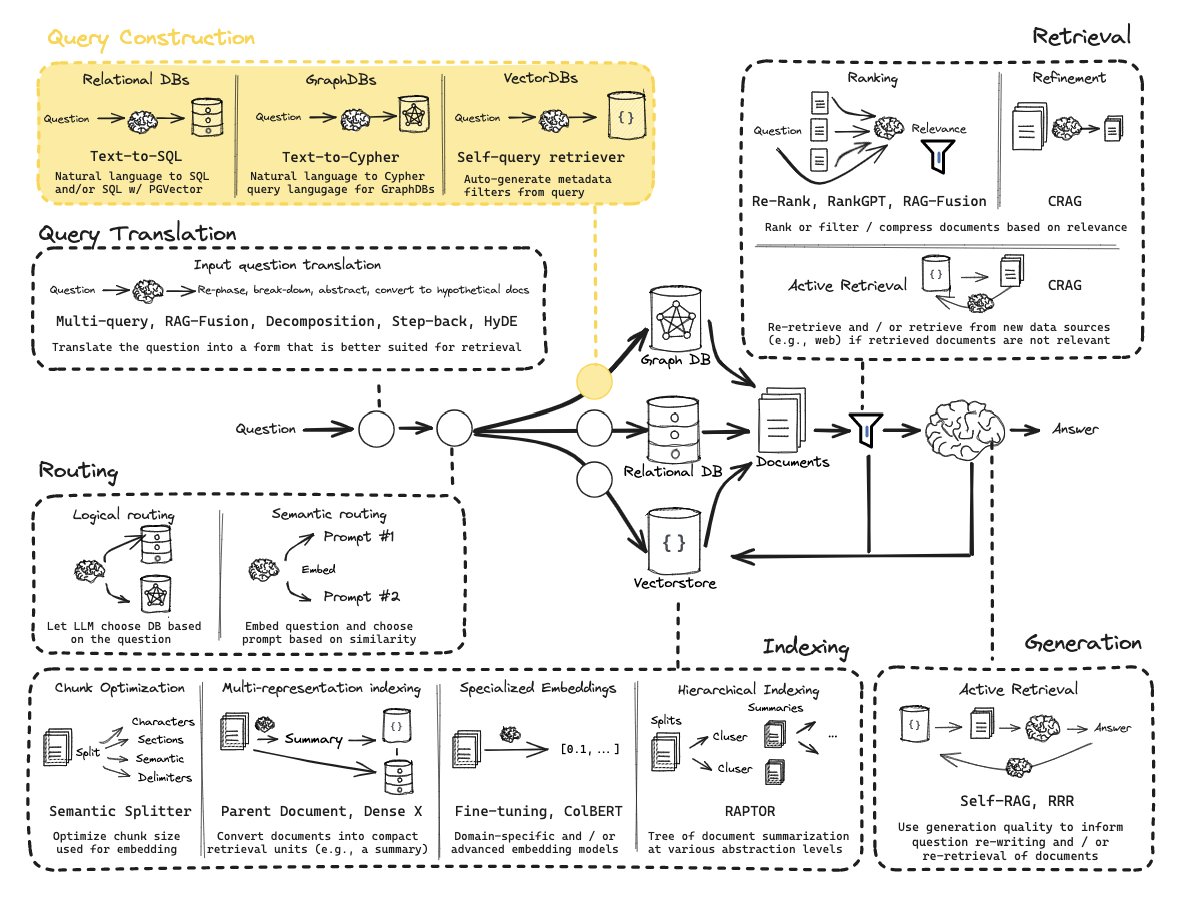

## Part 11: Query structuring for metadata filters

Flow:

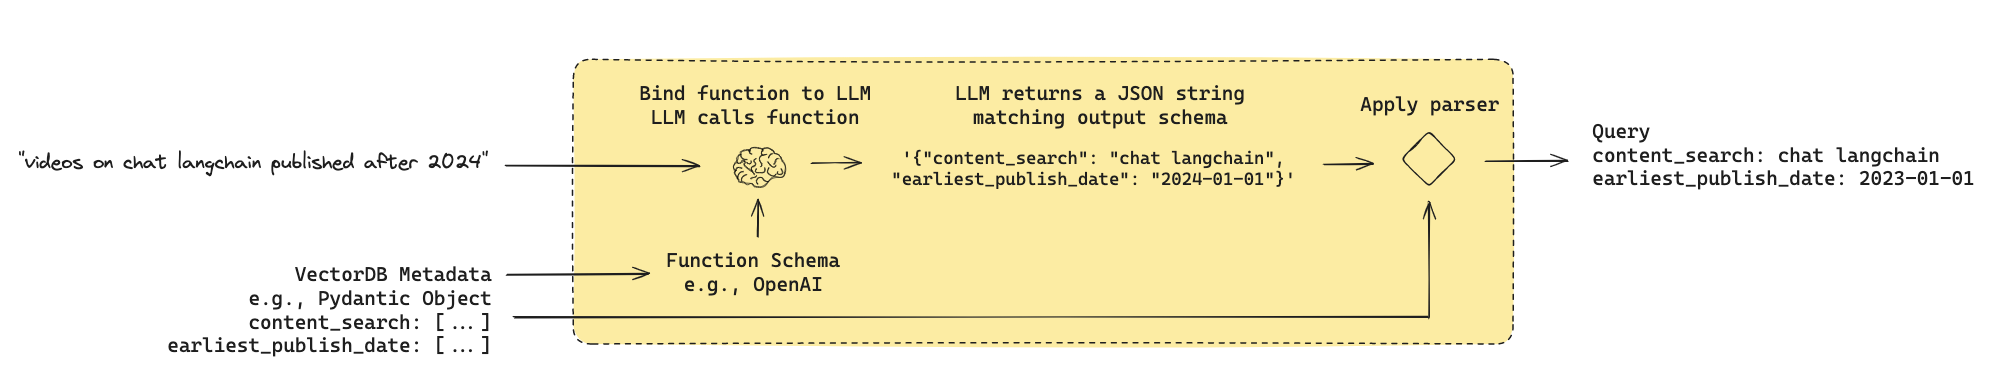

Many vectorstores contain metadata fields.

This makes it possible to filter for specific chunks based on metadata.

Let's look at some example metadata we might see in a database of YouTube transcripts.

In [9]:
from langchain_community.document_loaders import YoutubeLoader

docs = YoutubeLoader.from_youtube_url(
    "https://www.youtube.com/watch?v=pbAd8O1Lvm4", add_video_info=False
).load()

print(docs[0].metadata)  # This should work fine

{'source': 'pbAd8O1Lvm4'}


In [13]:
from yt_dlp import YoutubeDL

def get_video_info(video_url):
    ydl_opts = {}
    with YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(video_url, download=False)
        return {
            "title": info.get("title", "Unknown"),
            "description": info.get("description", "Unknown"),
            "view_count": info.get("view_count", 0),
            "thumbnail_url": info.get("thumbnail", "Unknown"),
            "publish_date": info.get("upload_date", "Unknown"),
            "length": info.get("duration", 0),
            "author": info.get("uploader", "Unknown"),
        }

video_info = get_video_info("https://www.youtube.com/watch?v=pbAd8O1Lvm4")
print(video_info)

[youtube] Extracting URL: https://www.youtube.com/watch?v=pbAd8O1Lvm4
[youtube] pbAd8O1Lvm4: Downloading webpage
[youtube] pbAd8O1Lvm4: Downloading tv client config
[youtube] pbAd8O1Lvm4: Downloading player e7567ecf
[youtube] pbAd8O1Lvm4: Downloading tv player API JSON
[youtube] pbAd8O1Lvm4: Downloading ios player API JSON
[youtube] pbAd8O1Lvm4: Downloading m3u8 information


{'title': 'Self-reflective RAG with LangGraph: Self-RAG and CRAG', 'description': 'Self-reflection can greatly enhance RAG, enabling correction of poor quality retrieval or generations. Several recent RAG papers focus on this theme, but implementing the ideas can be tricky. Here, we show that LangGraph can be easily used for "flow engineering" of self-reflective RAG pipelines. We provide cookbooks for implementing ideas from two interesting papers, Self-RAG and C-RAG.\n\nCode:\nhttps://github.com/langchain-ai/langgraph/tree/main/examples/rag', 'view_count': 29258, 'thumbnail_url': 'https://i.ytimg.com/vi/pbAd8O1Lvm4/maxresdefault.jpg', 'publish_date': '20240207', 'length': 1058, 'author': 'LangChain'}


Let’s assume we’ve built an index that:

Allows us to perform unstructured search over the contents and title of each document
And to use range filtering on view count, publication date, and length.
We want to convert natural langugae into structured search queries.

We can define a schema for structured search queries.

In [14]:
import datetime
from typing import Literal, Optional, Tuple
from langchain_core.pydantic_v1 import BaseModel, Field

class TutorialSearch(BaseModel):
    """Search over a database of tutorial videos about a software library."""

    content_search: str = Field(
        ...,
        description="Similarity search query applied to video transcripts.",
    )
    title_search: str = Field(
        ...,
        description=(
            "Alternate version of the content search query to apply to video titles. "
            "Should be succinct and only include key words that could be in a video "
            "title."
        ),
    )
    min_view_count: Optional[int] = Field(
        None,
        description="Minimum view count filter, inclusive. Only use if explicitly specified.",
    )
    max_view_count: Optional[int] = Field(
        None,
        description="Maximum view count filter, exclusive. Only use if explicitly specified.",
    )
    earliest_publish_date: Optional[datetime.date] = Field(
        None,
        description="Earliest publish date filter, inclusive. Only use if explicitly specified.",
    )
    latest_publish_date: Optional[datetime.date] = Field(
        None,
        description="Latest publish date filter, exclusive. Only use if explicitly specified.",
    )
    min_length_sec: Optional[int] = Field(
        None,
        description="Minimum video length in seconds, inclusive. Only use if explicitly specified.",
    )
    max_length_sec: Optional[int] = Field(
        None,
        description="Maximum video length in seconds, exclusive. Only use if explicitly specified.",
    )

    def pretty_print(self) -> None:
        for field in self.__fields__:
            if getattr(self, field) is not None and getattr(self, field) != getattr(
                self.__fields__[field], "default", None
            ):
                print(f"{field}: {getattr(self, field)}")

/opt/anaconda3/envs/ollama-rag/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3579: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [16]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_community.llms import Ollama

system = """You are an expert at converting user questions into database queries. \
You have access to a database of tutorial videos about a software library for building LLM-powered applications. \
Given a question, return a database query optimized to retrieve the most relevant results.

If there are acronyms or words you are not familiar with, do not try to rephrase them."""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
# llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
llm = Ollama(model="llama3.2")
structured_llm = llm.with_structured_output(TutorialSearch)
query_analyzer = prompt | structured_llm

NotImplementedError: 

In [17]:
query_analyzer.invoke({"question": "rag from scratch"}).pretty_print()

NameError: name 'query_analyzer' is not defined

In [18]:
query_analyzer.invoke(
    {"question": "videos on chat langchain published in 2023"}
).pretty_print()

NameError: name 'query_analyzer' is not defined

In [19]:
query_analyzer.invoke(
    {"question": "videos that are focused on the topic of chat langchain that are published before 2024"}
).pretty_print()


NameError: name 'query_analyzer' is not defined

In [20]:
query_analyzer.invoke(
    {
        "question": "how to use multi-modal models in an agent, only videos under 5 minutes"
    }
).pretty_print()

NameError: name 'query_analyzer' is not defined